In [5]:
from pauli import SiteBasis, PauliString, PauliSum
from hamiltonians import transverse_field_ising_model

import qics as qc
from qics.cones import OpPerspecEpi
from qics.vectorize import vec_to_mat
import numpy as np
from scipy.sparse import csr_array
import matplotlib.pyplot as plt

<h2>Directly in QICS:</h2>

In [8]:
def schwinger_dyson(hamil: PauliSum, word1: str) -> PauliSum:
    return hamil | PauliSum(word1)

def construct_lin(L: int, basis: SiteBasis, hamil: PauliSum, beta: float):
    n = basis.size()
    consC, consA, consAt = [], [], []
    b = []
    def add_row():
        consC.append(np.zeros((1, 2 * n * n)))
        consA.append(np.zeros((1, 2 * n * n)))
        consAt.append(np.zeros((1, 2 * n * n)))
        b.append(0.0)
    # I have to explicitly set imaginary parts to 0.0 for the raw expectation values
    # Those are encoded in the first row of A
    # Add normalization
    # Real part is 1.0
    add_row()
    consA[-1][0, 2 * basis.rank('I' * L)] = 1.0
    b[-1] = 1.0
    # Imaginary part is 0.0 but that is set later in setting up A
    # Add <[H, O]> = 0
    for op in basis._ops:
        psum = schwinger_dyson(hamil, op)
        if psum.is_zero():
            continue
        # <[H, O]> is always imaginary, but I'll still calculate the real part just in case
        # Because what if I'm wrong...
        psum_real = PauliSum({label: np.real(weight) for label, weight in psum.terms.items()})
        psum_imag = PauliSum({label: np.imag(weight) for label, weight in psum.terms.items()})
        if not psum_real.is_zero():
            # Set the real part of the equation to 0.0
            add_row()
            for pstr, weight in psum_real.terms.items():
                consA[-1][0, 2 * basis.rank(str(pstr))] = weight
        if not psum_imag.is_zero():
            # Set the imaginary part of the equation to 0.0
            add_row()
            for pstr, weight in psum_imag.terms.items():
                consA[-1][0, 2 * basis.rank(str(pstr))] = weight
    # Set matrix elements
    # Set A
    for i, o1 in enumerate(basis._ops):
        for j, o2 in enumerate(basis._ops):
            # In the first row of A, I need to ensure that all values have zero imaginary part
            # For all other elements of A.T and C, I just have to set their real and imaginary
            # parts equal to the first row of A
            if i == 0:
                add_row()
                # I am assuming that i = 0 corresponds to o1 = <Identity>
                consA[-1][0, 2 * j + 1] = 1.0
            else:
                p1, p2 = PauliString(o1), PauliString(o2)
                p3 = p1 * p2
                phase = p1.phase(p2)
                # Set real part
                add_row()
                consA[-1][0, 2 * n * i + 2 * j] = 1.0
                consA[-1][0, 2 * basis.rank(str(p3))] = -np.real(phase)
                # Set imag part
                add_row()
                consA[-1][0, 2 * n * i + 2 * j + 1] = 1.0
                consA[-1][0, 2 * basis.rank(str(p3))] = -np.imag(phase)
    # Set A.T
    for i, o1 in enumerate(basis._ops):
        for j, o2 in enumerate(basis._ops):
            # p1, p2 = PauliString(o1), PauliString(o2)
            # p3 = p2 * p1
            # phase = p2.phase(p1)
            # # Set real part
            # add_row()
            # consAt[-1][0, 2 * n * i + 2 * j] = 1.0
            # consA[-1][0, 2 * basis.rank(str(p3))] = -np.real(phase)
            # # Set imag part
            # add_row()
            # consAt[-1][0, 2 * n * i + 2 * j + 1] = 1.0
            # consA[-1][0, 2 * basis.rank(str(p3))] = -np.imag(phase)
            # I just need to set A.T[i, j] == A[j, i]
            # Set real part
            add_row()
            consAt[-1][0, 2 * n * i + 2 * j] = 1.0
            consA[-1][0, 2 * n * j + 2 * i] = -1.0
            # Set imag part
            add_row()
            consAt[-1][0, 2 * n * i + 2 * j + 1] = 1.0
            consA[-1][0, 2 * n * j + 2 * i + 1] = -1.0
    # Set C
    for i, o1 in enumerate(basis._ops):
        for j, o2 in enumerate(basis._ops):
            psum = PauliSum(o1) * (hamil | PauliSum(o2))
            psum_real = PauliSum({label: np.real(weight) for label, weight in psum.terms.items()})
            psum_imag = PauliSum({label: np.imag(weight) for label, weight in psum.terms.items()})
            # Set real part
            add_row()
            consC[-1][0, 2 * n * i + 2 * j] = 1.0
            for pstr, weight in psum_real.terms.items():
                consA[-1][0, 2 * basis.rank(str(pstr))] = weight
            # Set imag part
            add_row()
            consC[-1][0, 2 * n * i + 2 * j + 1] = 1.0
            for pstr, weight in psum_imag.terms.items():
                consA[-1][0, 2 * basis.rank(str(pstr))] = weight
    # Now all matrices are set up
    # Stack them
    AC = np.vstack(consC)
    AA = np.vstack(consA)
    AAt = np.vstack(consAt)
    A = np.hstack([beta * AC, AA, AAt])
    b = np.vstack(b)
    return A, b

# Remember that all expectation values are real in the Ising model
def create_problem(L, beta):
    basis = SiteBasis(L, True)
    n = basis.size()
    H = transverse_field_ising_model(L, 1)
    A, b = construct_lin(L, basis, H, beta)
    cC = np.zeros((2 * n * n, 1))
    cA = np.zeros((2 * n * n, 1))
    cAt = np.zeros((2 * n * n, 1))
    cA[2 * basis.rank('XX'+'I'*(L-2)), 0] = cA[2 * basis.rank('Z'+'I'*(L-1)), 0] = -L
    if L == 2:
        cA[2 * basis.rank('XX'), 0] = -1.0
        cA[2 * basis.rank('ZI'), 0] = -2.0
    cones = [OpPerspecEpi(n, func="log", iscomplex=True)]
    return A, b, np.vstack([cC, cA, cAt]), cones

def solve(L, betas, verbose=True):
    mins, maxs = np.zeros_like(betas), np.zeros_like(betas)
    for i, beta in enumerate(betas):
        if verbose:
            print(f'Solving for T={1/beta}, i={i}:')
        A, b, c, cones = create_problem(L, beta)
        minmodel = qc.Model(c=c, A=A, b=b, cones=cones)
        # maxmodel = qc.Model(c=-c, A=A, b=b, cones=cones)
        minsolver = qc.Solver(minmodel, verbose=3)
        # maxsolver = qc.Solver(maxmodel, verbose=0)
        mininfo = minsolver.solve()
        # maxinfo = maxsolver.solve()
        # n = SiteBasis(L, True).size()
        # x = mininfo['x_opt']
        # with np.printoptions(linewidth=np.inf):
        #     C = vec_to_mat(x[:2 * n * n], iscomplex=True)
        #     A = vec_to_mat(x[2 * n * n: 4 * n * n], iscomplex=True)
        #     B = vec_to_mat(x[4 * n * n:], iscomplex=True)
        #     print(np.isclose(np.round(B, 4), np.round(A.T, 4)))
        #     print('C')
        #     print(np.round(C, 4))
        #     print('A')
        #     print(np.round(A, 4))
        #     print('B == A.T')
        #     print(np.round(B, 4))
        E_min = mininfo['p_obj']
        # E_max = -maxinfo['p_obj']
        if verbose:
            print(f'\tE_min = {E_min}')
            # print(f'\tE_max = {E_max}')
        # mins[i], maxs[i] = E_min, E_max
    return mins, maxs


In [9]:
betas = 1/np.linspace(1, 4, num = 1)
L = 2
mins, maxs = solve(L, betas)

Solving for T=1.0, i=0:
           QICS v1.1.3 - Quantum Information Conic Solver           
              by K. He, J. Saunderson, H. Fawzi (2024)              
Problem summary:
	no. vars:     600       		barr. par:    31        
	no. constr:   599       		symmetric:    False     
	cone dim:     600       		complex:      True      
	no. cones:    1         		sparse:       True      

 iter     mu        k/t    |    p_obj       d_obj       gap    |  p_feas    d_feas   |  time (s)  |   step    dir_tol    prox     alpha
    0   1.0e+00   1.0e+00  |  0.000e+00   0.000e+00   0.0e+00  |  1.3e+00   5.9e-01  |  0.00      |  co_toa   1.9e+00   5.7e-02   0.500
    1   5.0e-01   9.2e-01  |  3.769e-01   6.289e-01   2.5e-01  |  8.6e-01   3.9e-01  |  0.07      |  co_toa   8.8e-01   8.9e-01   0.700
    2   1.5e-01   5.9e-01  |  1.063e+00   1.376e+00   2.9e-01  |  3.6e-01   1.6e-01  |  0.11      |  co_toa   7.8e-01   2.1e-01   0.500
    3   7.5e-02   9.1e-01  |  1.245e+00   1.895e+00   5.2e-01  |  3.

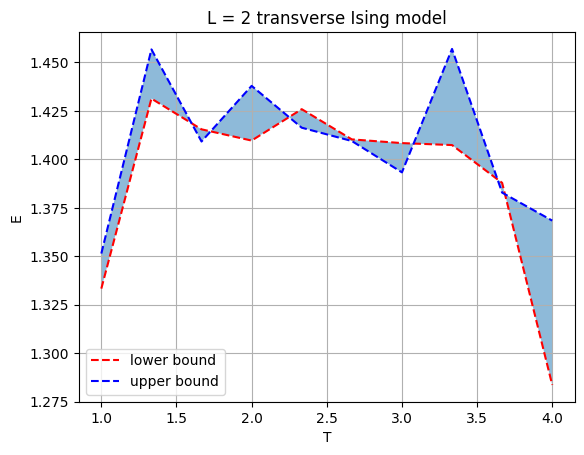

In [4]:
plt.fill_between(1/betas, mins, maxs, alpha = 0.5)
plt.plot(1/betas, mins,c ='red',linestyle='--',label='lower bound')
plt.plot(1/betas, maxs,c ='blue',linestyle='--',label='upper bound')
plt.xlabel('T')
plt.ylabel('E')
plt.title(f'L = {L} transverse Ising model')
plt.legend()
plt.grid()
plt.show()